## Donwload Data from Kaggle

In [1]:
!kaggle datasets download hafiznouman786/potato-plant-diseases-data

Dataset URL: https://www.kaggle.com/datasets/hafiznouman786/potato-plant-diseases-data
License(s): CC0-1.0
100% 75.7M/75.7M [00:03<00:00, 33.6MB/s]
100% 75.7M/75.7M [00:03<00:00, 24.2MB/s]


In [2]:
!unzip -q /content/potato-plant-diseases-data.zip -d /content/potato-plant-diseases-data
!rm -rf /content/potato-plant-diseases-data.zip

## Prepare Data & Seperate as `healthy` & `blight`

In [3]:
!mkdir PotatoPlantDiseasesData
!mkdir PotatoPlantDiseasesData/healthy
!mkdir PotatoPlantDiseasesData/blight

In [4]:
!mv /content/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___healthy/* /content/PotatoPlantDiseasesData/healthy
!mv /content/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___Late_blight/* /content/PotatoPlantDiseasesData/blight
!mv /content/potato-plant-diseases-data/PlantVillage/PlantVillage/Potato___Early_blight/* /content/PotatoPlantDiseasesData/blight

In [5]:
!rm -rf /content/potato-plant-diseases-data

## Imports

In [6]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

import os
import pathlib

## Use GPU

In [7]:
!nvidia-smi

Tue Jul  2 20:24:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Analyze the Data

In [8]:
def display_random_image(dir, class_type):
  image_dir = pathlib.Path(dir) / class_type
  files = os.listdir(image_dir)

  image_name = random.choice(files)
  image_dir /= image_name

  image = mpimg.imread(image_dir)

  plt.imshow(image)
  plt.title(class_type)
  plt.axis("off")

  print(f"Image Shape: {image.shape}")

Image Shape: (256, 256, 3)


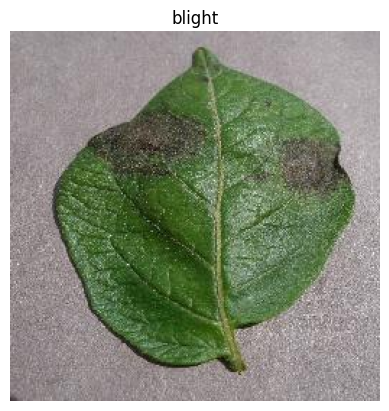

In [9]:
display_random_image("/content/PotatoPlantDiseasesData", "blight")

Image Shape: (256, 256, 3)


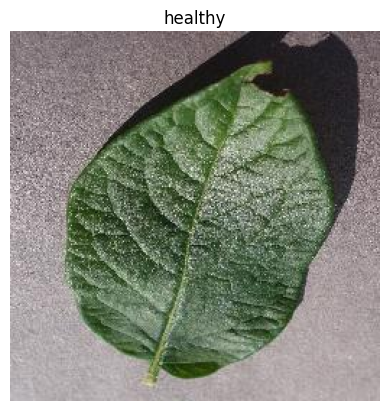

In [10]:
display_random_image("/content/PotatoPlantDiseasesData", "healthy")

## Prepare Data

In [11]:
data_dir = "/content/PotatoPlantDiseasesData"

training_data = keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split=0.2,
                                                         subset="training",
                                                         batch_size=32,
                                                         image_size=(256,256),
                                                         seed=15)

validation_data = keras.utils.image_dataset_from_directory(data_dir,
                                                         validation_split=0.2,
                                                         subset="validation",
                                                         batch_size=32,
                                                         image_size=(256,256),
                                                         seed=15)

Found 2152 files belonging to 2 classes.
Using 1722 files for training.
Found 2152 files belonging to 2 classes.
Using 430 files for validation.


In [12]:
class_names = training_data.class_names
print(class_names)

['blight', 'healthy']


## Normalize the Data

In [13]:
normalizer = layers.Rescaling(1/255.0)

training_data_norm = training_data.map(lambda x,y: (normalizer(x), y))
validation_data_norm = validation_data.map(lambda x,y: (normalizer(x), y))

In [14]:
images_batch, labels_batch = next(iter(training_data_norm))

images_batch[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.58431375, 0.56078434, 0.5686275 ],
        [0.5764706 , 0.5529412 , 0.56078434],
        [0.5764706 , 0.5529412 , 0.56078434],
        ...,
        [0.6431373 , 0.61960787, 0.63529414],
        [0.6509804 , 0.627451  , 0.6431373 ],
        [0.67058825, 0.64705884, 0.6627451 ]],

       [[0.57254905, 0.54901963, 0.5568628 ],
        [0.57254905, 0.54901963, 0.5568628 ],
        [0.5764706 , 0.5529412 , 0.56078434],
        ...,
        [0.6431373 , 0.61960787, 0.63529414],
        [0.6431373 , 0.61960787, 0.63529414],
        [0.654902  , 0.6313726 , 0.64705884]],

       [[0.57254905, 0.54901963, 0.5568628 ],
        [0.5803922 , 0.5568628 , 0.5647059 ],
        [0.5882353 , 0.5647059 , 0.57254905],
        ...,
        [0.654902  , 0.6313726 , 0.64705884],
        [0.6627451 , 0.6392157 , 0.654902  ],
        [0.6784314 , 0.654902  , 0.67058825]],

       ...,

       [[0.5137255 , 0.47450984, 0.47058827],
        [0.48

In [15]:
len(images_batch)

32

## Data Augmentation

In [16]:
data_augmentation = Sequential([
    layers.RandomFlip(),
    layers.RandomRotation(0.2)
])

## Build CNN Model

In [17]:
tf.random.set_seed(15)

model_1 = Sequential([
    data_augmentation,
    Conv2D(16, 3, input_shape=(256,256,3), activation="relu"),
    MaxPool2D(pool_size=3),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="relu"),
    Dense(1, activation="sigmoid")
])

model_1.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

history_1 = model_1.fit(
    training_data_norm,
    epochs=20,
    steps_per_epoch=len(training_data_norm),
    validation_data=validation_data_norm,
    validation_steps=len(validation_data_norm)
)

Epoch 1/20
54/54 [==============================] - 10s 57ms/step - loss: 0.3493 - accuracy: 0.9117 - val_loss: 0.2512 - val_accuracy: 0.9349
Epoch 2/20
54/54 [==============================] - 2s 42ms/step - loss: 0.2634 - accuracy: 0.9280 - val_loss: 0.2414 - val_accuracy: 0.9349
Epoch 3/20
54/54 [==============================] - 4s 78ms/step - loss: 0.2553 - accuracy: 0.9280 - val_loss: 0.2381 - val_accuracy: 0.9349
Epoch 4/20
54/54 [==============================] - 3s 47ms/step - loss: 0.2347 - accuracy: 0.9280 - val_loss: 0.2160 - val_accuracy: 0.9349
Epoch 5/20
54/54 [==============================] - 3s 43ms/step - loss: 0.2104 - accuracy: 0.9280 - val_loss: 0.1751 - val_accuracy: 0.9349
Epoch 6/20
54/54 [==============================] - 3s 52ms/step - loss: 0.1649 - accuracy: 0.9280 - val_loss: 0.1230 - val_accuracy: 0.9349
Epoch 7/20
54/54 [==============================] - 2s 41ms/step - loss: 0.1115 - accuracy: 0.9280 - val_loss: 0.0825 - val_accuracy: 0.9349
Epoch 8/20
5

In [18]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 84, 84, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 82, 82, 10)        1450      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 41, 41, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 39, 39, 10)       

In [19]:
train_loss, train_acc = model_1.evaluate(training_data_norm, verbose=0)
print(f"Training Accuracy : {train_acc}")
print(f"Training Loss     : {train_loss}")

Training Accuracy : 0.9628339409828186
Training Loss     : 0.09611682593822479


In [20]:
val_loss, val_acc = model_1.evaluate(validation_data_norm, verbose=0)
print(f"Validation Accuracy : {val_acc}")
print(f"Validation Loss     : {val_loss}")

Validation Accuracy : 0.9790697693824768
Validation Loss     : 0.08032375574111938


### Plot Loss & Accuracy

<Axes: >

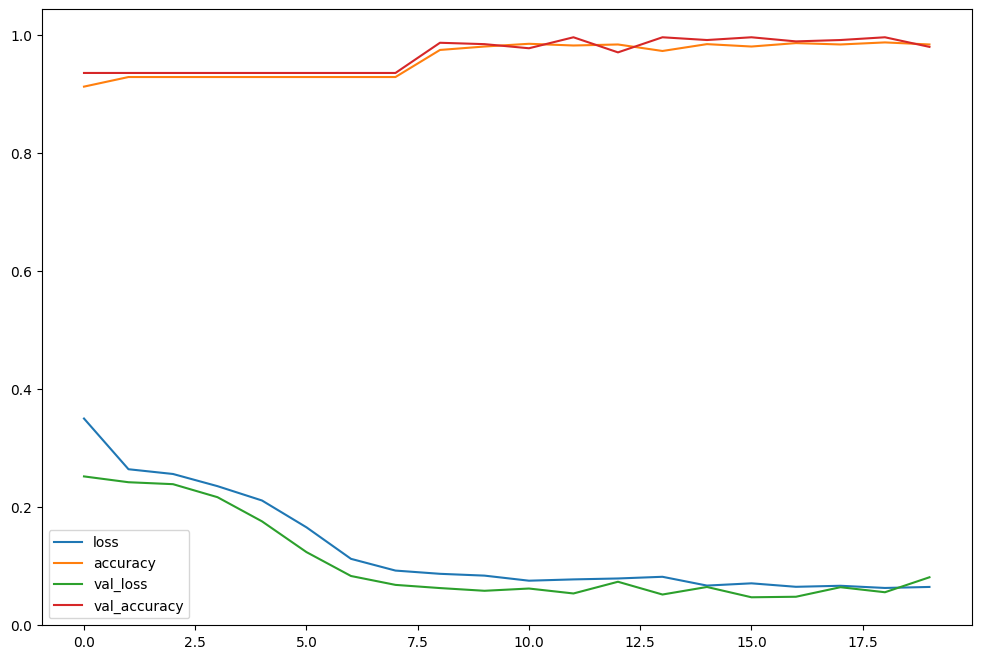

In [21]:
pd.DataFrame(history_1.history).plot(figsize=(12,8))

## Save the Model

In [22]:
model_1.save("PotatoPlantDisaseClassifier.keras")

## Load the Model

In [23]:
model = keras.models.load_model("/content/PotatoPlantDisaseClassifier.keras")

## Make Predcition on different image

In [24]:
from urllib.request import urlopen
from PIL import Image

Image Shape: (262, 335, 3)


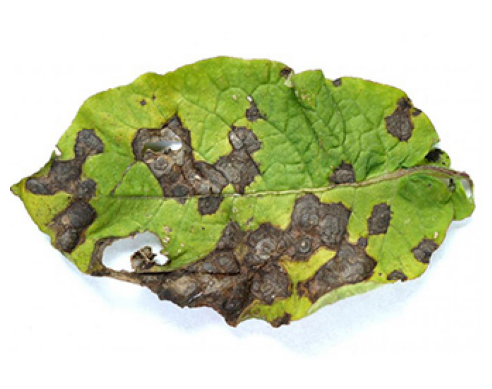

In [25]:
image_url = "https://projectbluearchive.blob.core.windows.net/media/Default/Potatoes/Disease%20and%20defects/Alternaria%20Leaf%20resized.jpg"
image = np.array(Image.open(urlopen(image_url)))

plt.imshow(image)
plt.axis("off")

print(f"Image Shape: {image.shape}")

In [26]:
# Resize image
image = tf.image.resize(image, size=(256,256))

# Normalize image
image = image / 255.0

In [27]:
prediction = model.predict(tf.expand_dims(image, axis=0), verbose=0)
prediction

array([[7.681232e-23]], dtype=float32)

In [28]:
class_names

['blight', 'healthy']

In [29]:
predicted_class = class_names[int(tf.round(prediction))]
predicted_class

'blight'